In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

In [2]:
with open('../data/Korean_movie_reviews_2016_small.txt', encoding='utf-8') as f:
    docs = [doc.strip().split('\t') for doc in f ]
    docs = [(doc[0], int(doc[1])) for doc in docs if len(doc) == 2]
    texts, labels = zip(*docs)

In [3]:
len(texts)

29875

In [4]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

In [5]:
tokenizer = DistilBertTokenizer.from_pretrained("monologg/distilkobert")

In [6]:
from tensorflow.keras.utils import to_categorical
y_one_hot = to_categorical(labels)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(texts, y_one_hot, test_size=0.2, random_state=0)

In [8]:
len(X_train)

23900

In [9]:
X_train_tokenized = tokenizer(X_train, return_tensors="np", max_length=30, padding='max_length', truncation=True)
X_test_tokenized = tokenizer(X_test, return_tensors="np", max_length=30, padding='max_length', truncation=True)

In [10]:
model = TFDistilBertForSequenceClassification.from_pretrained("monologg/distilkobert", num_labels=2, from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'cla

In [11]:
optimizer = tf.keras.optimizers.Adam(2e-5)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
checkpoint_filepath = "./checkpoints/checkpoint_distil_kr"
mc = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', mode='min', 
                     save_best_only=True, save_weights_only=True)

In [13]:
history = model.fit(dict(X_train_tokenized), y_train, epochs=20, batch_size=128, 
                    validation_split=0.1, callbacks=[es, mc])

Epoch 1/20
169/169 [==============================] - 243s 1s/step - loss: 0.6498 - accuracy: 0.6197 - val_loss: 0.6085 - val_accuracy: 0.6632
Epoch 2/20
169/169 [==============================] - 238s 1s/step - loss: 0.5703 - accuracy: 0.7044 - val_loss: 0.5579 - val_accuracy: 0.6987
Epoch 3/20
169/169 [==============================] - 239s 1s/step - loss: 0.5332 - accuracy: 0.7283 - val_loss: 0.5377 - val_accuracy: 0.7213
Epoch 4/20
169/169 [==============================] - 238s 1s/step - loss: 0.5149 - accuracy: 0.7394 - val_loss: 0.5352 - val_accuracy: 0.7167
Epoch 5/20
169/169 [==============================] - 234s 1s/step - loss: 0.4986 - accuracy: 0.7489 - val_loss: 0.5374 - val_accuracy: 0.7213
Epoch 6/20
169/169 [==============================] - 239s 1s/step - loss: 0.4889 - accuracy: 0.7574 - val_loss: 0.5226 - val_accuracy: 0.7251
Epoch 7/20
169/169 [==============================] - 235s 1s/step - loss: 0.4780 - accuracy: 0.7634 - val_loss: 0.5304 - val_accuracy: 0.7293

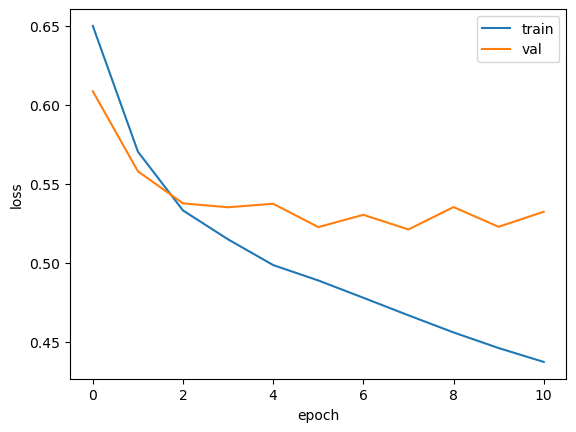

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

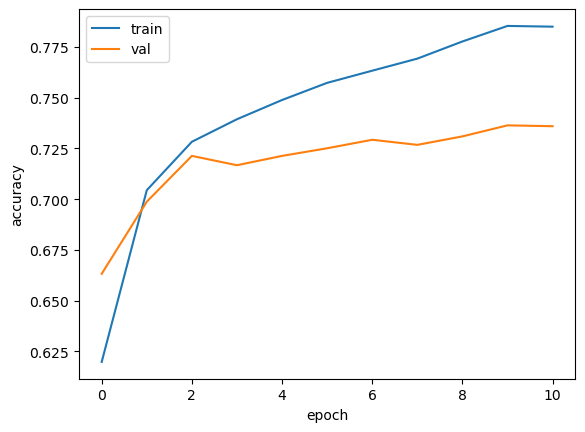

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'])
plt.show()

In [16]:
model.load_weights(checkpoint_filepath)
y_preds = model.predict(dict(X_test_tokenized))
prediction_probs = tf.nn.softmax(y_preds.logits,axis=1).numpy()
y_predictions = np.argmax(prediction_probs, axis=1)
y_test = np.argmax(y_test, axis=1)
from sklearn.metrics import classification_report
print(classification_report(y_predictions, y_test))

187/187 [==============================] - 22s 113ms/step
              precision    recall  f1-score   support

           0       0.67      0.75      0.71      2562
           1       0.80      0.73      0.76      3413

    accuracy                           0.74      5975
   macro avg       0.74      0.74      0.74      5975
weighted avg       0.74      0.74      0.74      5975

